Initialise code for google colab

Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [1]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_addons as tfa
print(tfa.__version__)

2.11.0
0.19.0


In [2]:
!pip install tensorflow==2.11
!pip install tensorflow-addons==0.19

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 81.9 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorboard
    Found existing i

Create data base files under google colab environment

In [2]:
!unzip -q '/content/drive/MyDrive/data_equalize.zip' -d '/content/'

Define working directory to our jupyter repertory:
* because path to the different repertories (./data, ./output...) are define relatevly to jupyter one
* let import _mypath which add ./lib to python path in order to import our own define libraries


In [3]:
# for google colab use
%cd /content/drive/MyDrive/covid-19-xRay/jupyter
from google.colab.patches import cv2_imshow
db_work_dir = '/content'


/content/drive/MyDrive/covid-19-xRay/jupyter


In [ ]:
# for local use
db_work_dir = '..'

In [4]:
import _mypath
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 1

In [5]:
%aimport database.path_origin_data
%aimport database.dataset

from database.path_origin_data import build_data_paths 
from database.path_origin_data import lung_name, infection_name
from database.path_origin_data import train_name, test_name, valid_name
from database.path_origin_data import normal_name, covid_name, no_covid_name
from database.path_origin_data import images_name, lung_mask_name, infection_mask_name


Build paths and variables for reading data base hierarchy

In [6]:
# input
db_name = 'data_equalize'
db_path = os.path.join(db_work_dir, db_name)

# output
output_path = os.path.join('..', 'output', 'cnn_transformer')
if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok=True)

log_path = os.path.join(output_path, 'log')
if not os.path.exists(log_path):
    os.makedirs(log_path, exist_ok=True)

ckpt_path = os.path.join(output_path, 'ckpt')
if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path, exist_ok=True)

metric_path = os.path.join(output_path, 'metric')
if not os.path.exists(metric_path):
    os.makedirs(metric_path, exist_ok=True)


activation_path = os.path.join(output_path, 'activation')
if not os.path.exists(activation_path):
    os.makedirs(activation_path, exist_ok=True)

pattern_path = os.path.join(output_path, 'pattern')
if not os.path.exists(pattern_path):
    os.makedirs(pattern_path, exist_ok=True)

occultation_path = os.path.join(output_path, 'occulatation')
if not os.path.exists(occultation_path):
    os.makedirs(occultation_path, exist_ok=True)

grad_cam_path = os.path.join(output_path, 'grad_cam')
if not os.path.exists(grad_cam_path):
    os.makedirs(grad_cam_path, exist_ok=True)


Learning curves

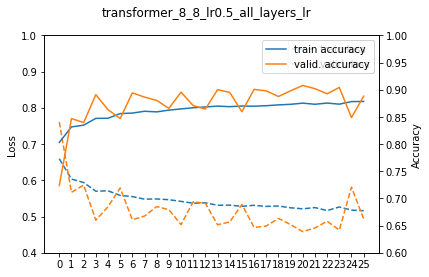

In [147]:
# nn_name = 'cnn'
# nn_name = 'pure_cnn_lr0.001'
# nn_name = 'transformer_8_8_lr0.5'
nn_name = 'transformer_8_8_lr0.5_all_layers_lr'
# nn_name = 'transformer_8_8_lr0.5_all_layers_lr_fine_tuning_lr0.0001'

learning_df = pd.read_csv(os.path.join(log_path, nn_name + '_log.csv'))
# print(learning_df.head(25))

fig, ax1 = plt.subplots()
fig.suptitle(nn_name)

epoch = learning_df['epoch']

ax1.set_ylim(0.4, 1.)
ax1.set_ylabel("Loss")
ax1.plot(epoch, learning_df['loss'], '--', label='train loss')
ax1.plot(epoch, learning_df['val_loss'], '--', label='valid. loss')
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_xticks(epoch)
ax2.set_xlabel("Num epoch")
ax2.set_ylim(0.6, 1.)
ax2.set_ylabel("Accuracy")
ax2.plot(epoch, learning_df['accuracy'], label='train accuracy')
ax2.plot(epoch, learning_df['val_accuracy'], label='valid. accuracy')
ax2.legend()

plt.savefig(os.path.join(metric_path, nn_name + '_learning_curves.png'), format='png')
plt.show()


Structure to manage paths in data base

In [7]:
data_paths = build_data_paths()
idx = pd.IndexSlice

Model parameters

In [8]:
image_size = 256
input_shape = (image_size, image_size, 1)

# data augmentation
scale = 1. / 255.
flip = "horizontal"
rotation_factor = 10. / 360.
zoom_height_factor = 0.2
zoom_width_factor = 0.2

# vit
patch_size = 1
transformer_layers = 4
num_heads = 8
projection_dim = 64
transformer_units_rate = [2, 1]
mlp_head_units = [1024, 256]  # Size of the dense layers of the final classifier


Data augmentation

In [9]:
augmentation = keras.Sequential(
    [
      layers.Rescaling(scale=scale),
      layers.RandomFlip(flip),
      layers.RandomRotation(rotation_factor),
      layers.RandomZoom(height_factor=zoom_height_factor, width_factor=zoom_width_factor),
    ],
    name='augmentation'
)

cnn encoder

In [10]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout

encoder = keras.Sequential(
    [
      layers.Conv2D(128, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(128, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Flatten(),
    ],
    name='encoder'
)

Build model

In [11]:
shared_encoder = keras.Sequential(name='shared_encoder')
for layer in encoder.layers[:-1]:
  shared_encoder.add(layer)

In [12]:
%aimport myLayers.vision_transformer
%aimport myLayers.mlp
from myLayers.vision_transformer import add_vit
from myLayers.mlp import mlp

inputs = layers.Input(shape=input_shape)
augmented = augmentation(inputs)
shared_encoded = shared_encoder(augmented)
features = add_vit(shared_encoded,
            patch_size=patch_size,
            input_image_size=shared_encoded.shape[1],
            transformer_layers=transformer_layers,
            num_heads=num_heads,
            projection_dim=projection_dim,
            transformer_units_rate=transformer_units_rate,
            mlp_head_units=mlp_head_units)
# Classify outputs.
softmax = layers.Dense(3, activation='softmax', kernel_initializer='random_normal')(features)

# Create the Keras model
model = keras.Model(inputs=inputs, outputs=softmax)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 augmentation (Sequential)      (None, 256, 256, 1)  0           ['input_1[0][0]']                
                                                                                                  
 shared_encoder (Sequential)    (None, 8, 8, 64)     296512      ['augmentation[0][0]']           
                                                                                                  
 patches (Patches)              (None, None, 64)     0           ['shared_encoder[0][0]']     

In [13]:
checkpoint_filename = os.path.join(ckpt_path, 'transformer_8_8_lr0.5_all_layers_lr_fine_tuning_lr0.0001_weights.hdf5')
model.load_weights(checkpoint_filename)

model.get_layer('shared_encoder').summary()

Model: "shared_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)    

In [14]:
def extract_conv_model(model, layer_index, encoder_name='shared_encoder'):
  encoder_index = 0
  for i, layer in enumerate(model.layers):
    if layer.name == encoder_name:
      encoder_index = i
      break
  # print(encoder_index)

  pre_model = keras.Model(model.input, model.layers[encoder_index-1].get_output_at(0))
  eff_net = keras.Model(model.layers[encoder_index].layers[0].input, model.layers[encoder_index].layers[layer_index].get_output_at(0))
  until_conv_model = keras.Model(pre_model.input, eff_net.call(pre_model.output))
  return until_conv_model

encoder_name = 'shared_encoder'

In [15]:
path = data_paths['path'].loc[idx[[lung_name], [test_name], [normal_name], [images_name]]][0]
image_path = os.path.join(db_path, path)
list_file_name_normal = os.listdir(image_path)
list_file_name_normal = [os.path.join(image_path, file_name) for file_name in list_file_name_normal]

path = data_paths['path'].loc[idx[[lung_name], [test_name], [covid_name], [images_name]]][0]
image_path = os.path.join(db_path, path)
list_file_name_covid = os.listdir(image_path)
list_file_name_covid = [os.path.join(image_path, file_name) for file_name in list_file_name_covid]

path = data_paths['path'].loc[idx[[lung_name], [test_name], [no_covid_name], [images_name]]][0]
image_path = os.path.join(db_path, path)
list_file_name_no_covid = os.listdir(image_path)
list_file_name_no_covid = [os.path.join(image_path, file_name) for file_name in list_file_name_no_covid]


In [95]:
# list_file_name = list_file_name_normal
# image_label = 'normal'
list_file_name = list_file_name_covid
image_label = 'covid'
# list_file_name = list_file_name_no_covid
# image_label = 'no-covid'

image_file_name = list_file_name[100]
image_file_name

'/content/data_equalize/Lung Segmentation Data/Test/COVID-19/images/sub-S09457_ses-E18156_run-1_bp-chest_vp-ap_dx.png'

Visualization of activation in conv layer

In [17]:
model_shared_encoder_4 = extract_conv_model(model, 4, encoder_name=encoder_name)

# Load image
img = keras.preprocessing.image.load_img(
    image_file_name,
    target_size=(image_size, image_size),
    grayscale=True)
img = keras.preprocessing.image.img_to_array(img)

# Get the outputs of layers we want to inspect
outputs = [model_shared_encoder_4.output]

# Create a connection between the input and those target outputs
activations_model = keras.Model(model.input, outputs=outputs)
activations_model.compile(optimizer='adam', loss='categorical_crossentropy')

# Get their outputs
activations = activations_model.predict(np.array([img]))[0]

/usr/local/lib/python3.8/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 282ms/step


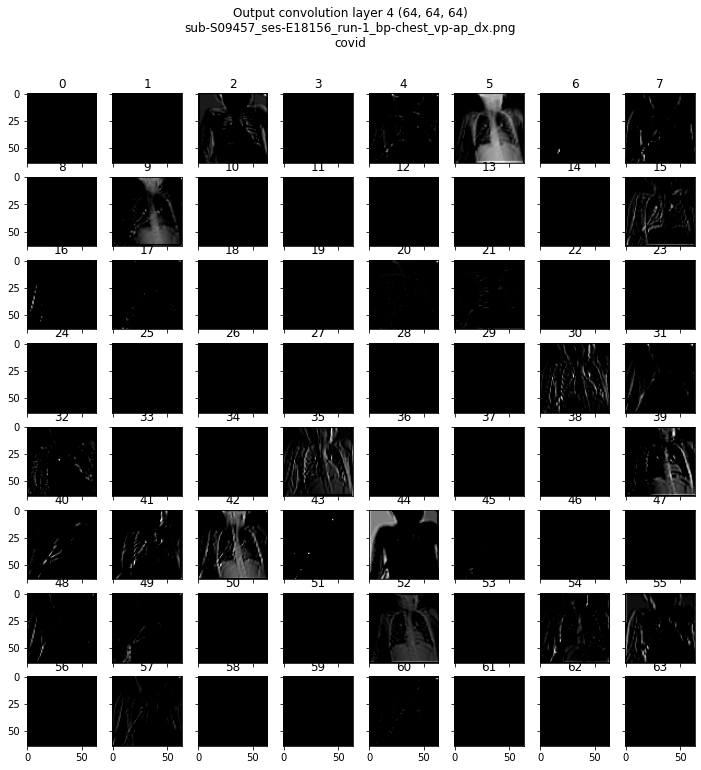

In [18]:
nrows = 8
ncols = 8
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(12, 12))
num_filer = min(nrows*ncols, activations.shape[-1])
for i in range(num_filer):
    image = activations[:, :, i]   
    ax.flatten()[i].imshow(image, cmap='gray')
    ax.flatten()[i].set_title(str(i))

base_name = os.path.basename(image_file_name)
fig.suptitle('Output convolution layer 4 (64, 64, 64)\n' + base_name + '\n' + image_label)
plt.savefig(os.path.join(activation_path, 'activation_' + base_name + '_' + image_label + '.png'), format='png')
plt.show()


In [19]:
def build_pattern(submodel, pattern_size, filter_index, epochs, step_size):
  # Initiate random noise
  input_img_data = np.random.random((1, pattern_size, pattern_size, 1))
  input_img_data = (input_img_data - 0.5) * 127 + 128.
  # input_img_data = 128. * np.ones((1, pattern_size, pattern_size, 1))

  # Cast random noise from np.float64 to tf.float32 Variable
  input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

  # Iterate gradient ascents
  for _ in range(epochs):
      with tf.GradientTape() as tape:
          outputs = submodel(input_img_data, training=False)
          loss_value = tf.reduce_mean(outputs[:, :, :, filter_index])
      grads = tape.gradient(loss_value, input_img_data)
      normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
      input_img_data.assign_add(normalized_grads * step_size)

  return input_img_data[0]

def build_pattern_list(submodel, pattern_size, nb_filter, epochs=100, step_size=1.):
  pattern_list = []
  for i in range(nb_filter):
    pattern_list.append(build_pattern(submodel, pattern_size, i, epochs, step_size))
  
  return pattern_list


In [20]:
conv_layers = tf.keras.Sequential(name='conv_layer')
# conv_layer_index = 0
# nb_filters = 128
# pattern_size = 3

# conv_layer_index = 2
# nb_filters = 128
# pattern_size = 7

# conv_layer_index = 4
# nb_filters = 64
# pattern_size = 13

conv_layer_index = 6
nb_filters = 64
pattern_size = 25

for layer in shared_encoder.layers[:conv_layer_index+1]:
  conv_layers.add(layer)

inputs_pattern_size = layers.Input(shape=(pattern_size, pattern_size, 1))
# augmented_input_pattern_size = augmentation(inputs_pattern_size)
conv_layers_input_pattern_size = conv_layers(inputs_pattern_size)

model_conv_layers_input_pattern_size = keras.Model(
    inputs=inputs_pattern_size,
    outputs=conv_layers_input_pattern_size
)
model_conv_layers_input_pattern_size.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 25, 25, 1)]       0         
                                                                 
 conv_layer (Sequential)     (None, 3, 3, 64)          259584    
                                                                 
Total params: 259,584
Trainable params: 259,584
Non-trainable params: 0
_________________________________________________________________


In [21]:
epochs = 100
step_size = 1.

pattern_list = build_pattern_list(
  model_conv_layers_input_pattern_size,
  pattern_size, nb_filters,
  epochs=epochs, step_size=step_size
)


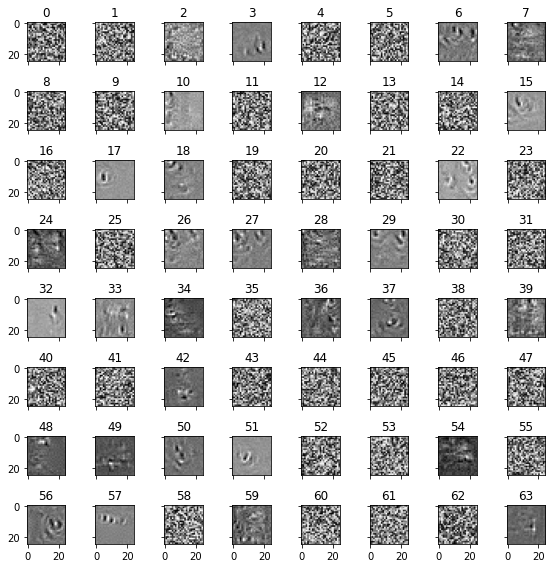

In [22]:
nrows = 8
ncols = nb_filters // nrows
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols, nrows))

num_filer = min(nrows*ncols, len(pattern_list))
for i in range(num_filer):
    image = pattern_list[i]
    ax.flatten()[i].imshow(np.squeeze(image), cmap='gray')
    ax.flatten()[i].set_title(str(i))

# fig.suptitle('Pattern convolution layer ' + str(conv_layer_index))
fig.tight_layout()
plt.savefig(os.path.join(pattern_path, 'pattern_conv_layer_' + str(conv_layer_index) + '.png'), format='png')
plt.show()


In [74]:
# Create function to apply a grey patch on an image
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 127.5

    return patched_image

def occultation(img, model, patch_size=32, sub_samp_for_step=4, pred_index=None):
    sensitivity_map = np.zeros((img.shape[0], img.shape[1]))
    count_map = np.zeros((img.shape[0], img.shape[1]))

    # Iterate the patch over the image
    i = 0
    for top_left_x in range(0, img.shape[0], patch_size // sub_samp_for_step):
        for top_left_y in range(0, img.shape[1], patch_size // sub_samp_for_step):
            patched_image = apply_grey_patch(img, top_left_x, top_left_y, patch_size)
            predictions = model.predict(np.array([patched_image]), verbose=False)[0]
            if pred_index is None:
                pred_index = tf.argmax(predictions)
            confidence = predictions[pred_index]
            
            # Save confidence for this specific patched image in map
            sensitivity_map[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] \
            = (sensitivity_map[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] \
            * count_map[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] \
            + confidence) \
            / (count_map[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] + 1)

            count_map[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] += 1
        print(str(i) + ',', end='')
        i += 1
    print('')       
          
    heatmap = 1. - (sensitivity_map - sensitivity_map.min()) / (sensitivity_map.max() - sensitivity_map.min())
    # heatmap = 1. - sensitivity_map / sensitivity_map.max()
    sens = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    occ = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, sens, 0.5, 0)

    return occ


def occultation_list(file_name_list, model, patch_size=32, sub_samp_for_step=4, pred_index=None):
    occ_list = []

    i = 0
    for file_name in file_name_list:
        img = keras.preprocessing.image.load_img(
          file_name,
          target_size=(image_size, image_size),
          color_mode = "grayscale")
        img = keras.preprocessing.image.img_to_array(img)

        print(str(i) + ':', end='')
        occ = occultation(
            img, model,
            patch_size=patch_size,
            sub_samp_for_step=sub_samp_for_step,
            pred_index=pred_index
        )
        
        occ_list.append(occ)

    return occ_list


In [104]:
# image_file_name = list_file_name[100]
# image_file_name = list_file_name[762]
# image_file_name = list_file_name[960]

ind = [i for i, f in enumerate(list_file_name) if 'S12816_ses-E27025_run-1_bp-chest_vp-pa_cr' in f]
print(ind)
image_file_name = list_file_name[ind[0]]


[1423]


In [79]:
occ = occultation_list(
    [image_file_name], model,
    patch_size=32, sub_samp_for_step=4, pred_index=None
)[0]


0:0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,


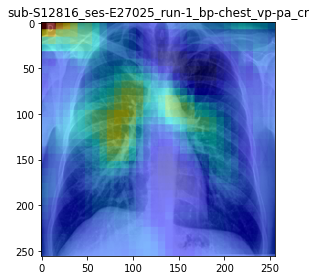

In [80]:
occ_RGB = cv2.cvtColor(occ, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(occ_RGB)

fig, ax = plt.subplots()
ax.imshow(im_pil)
f_name = os.path.splitext(os.path.basename(image_file_name))[0]
ax.set_title(f_name)
fig.tight_layout()

plt.savefig(os.path.join(occultation_path, 'occultation_' + f_name + '_' + image_label + '.png'), format='png')
plt.show()


In [81]:
def plot_image_list(
    image_list, nrows, ncols,
    fig_title, fig_file_name,
    output_path
):
  fig = plt.figure(figsize=(12, 12))
  fig.suptitle(fig_title)
  ax = fig.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
  for i, (image_list, file_name) in enumerate(zip(image_list, samples)):
    axe = ax.flatten()[i]

    img = cv2.cvtColor(image_list, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(img)

    axe.imshow(im_pil)
    f_name = os.path.basename(file_name)[:10]
    # print(f_name)
    axe.set_title(f_name)

  plt.savefig(os.path.join(output_path , fig_file_name + '.png'), format='png')
  plt.show()


In [92]:
from random import sample

nrows = 8
ncols = 8
num_img = nrows * ncols

samples = list_file_name
if (len(samples) >= num_img):
  samples = sample(samples, num_img)


In [ ]:
occ_list = occultation_list(
    samples, model,
    patch_size=32, sub_samp_for_step=4, pred_index=None
)

In [ ]:
fig_title = 'Occultation ' + image_label
fig_file_name = 'occultation_' + image_label
plot_image_list(
    occ_list, nrows, ncols,
    fig_title, fig_file_name,
    occultation_path
)

In [83]:
def grad_cam(img, grad_model, resize_shape=None, pred_index=None):
  image_size = img.shape[0]

  with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]), training=False)
    if pred_index is None:
      pred_index = tf.argmax(predictions[0])
    loss = predictions[:, pred_index]
  
  output = conv_outputs[0]
  grads = tape.gradient(loss, conv_outputs)[0]

  gate_f = tf.cast(output > 0, 'float32')
  gate_r = tf.cast(grads > 0, 'float32')
  guided_grads = gate_f * gate_r * grads

  weights = tf.math.multiply(guided_grads, output)
  cam = tf.reduce_sum(weights, axis=-1).numpy()

  # if resize_shape is None:
  #     weights = tf.reduce_mean(guided_grads, axis=(0, 1))
  # else:
  #     weights = tf.reduce_mean(guided_grads, axis=(0,))
  # cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1).numpy()

  if resize_shape is not None:
      cam = cam.reshape(resize_shape)

  cam = cv2.resize(cam, (image_size, image_size))
  cam = np.maximum(cam, 0)
  # heatmap = (cam - cam.min()) / (cam.max() - cam.min())
  heatmap = cam / cam.max()

  cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  cam = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 0.5, 0)

  return cam

def grad_cam_list(file_name_list, grad_model, resize_shape=None, pred_index=None):
  cam_list = []

  for file_name in file_name_list:
    img = keras.preprocessing.image.load_img(
      file_name,
      target_size=(image_size, image_size),
      color_mode = "grayscale")
    img = keras.preprocessing.image.img_to_array(img)

    cam = grad_cam(img, grad_model, resize_shape=resize_shape, pred_index=None)
    cam_list.append(cam)

  return cam_list


In [93]:
output_conv_layer = model.get_layer(encoder_name).get_output_at(0)
resize_shape = None
# output_conv_layer = model_transformer.get_layer('layer_normalization_8').get_output_at(0)
# resize_shape = (8, 8)

grad_model = keras.Model(
  [model.input],
  [output_conv_layer, model.output])


In [107]:
cam = grad_cam_list([image_file_name], grad_model, resize_shape=resize_shape, pred_index=None)[0]

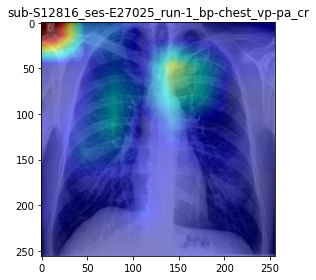

In [108]:
cam_RGB = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(cam_RGB)

fig, ax = plt.subplots()
ax.imshow(im_pil)
f_name = os.path.splitext(os.path.basename(image_file_name))[0]
ax.set_title(f_name)
fig.tight_layout()

plt.savefig(os.path.join(grad_cam_path, 'grad_cam_' + f_name + '_' + image_label + '.png'), format='png')
plt.show()

In [ ]:
cam_list = grad_cam_list(samples, grad_model, resize_shape=resize_shape, pred_index=None)


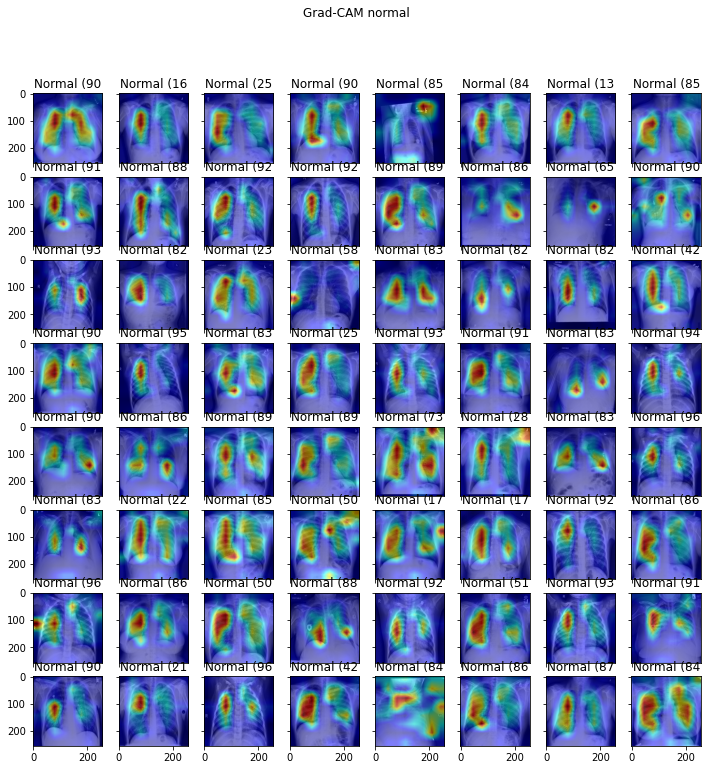

In [94]:
fig_title = 'Grad-CAM ' + image_label
fig_file_name = 'grad_cam_' + image_label
plot_image_list(
    cam_list, nrows, ncols,
    fig_title, fig_file_name,
    grad_cam_path
)
